# MLP Regression

In [2]:
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns
import tensorflow

In [4]:
df = sns.load_dataset("mpg").drop("name", axis = 1)
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin
0,18.0,8,307.0,130.0,3504,12.0,70,usa
1,15.0,8,350.0,165.0,3693,11.5,70,usa
2,18.0,8,318.0,150.0,3436,11.0,70,usa
3,16.0,8,304.0,150.0,3433,12.0,70,usa
4,17.0,8,302.0,140.0,3449,10.5,70,usa


In [5]:
df["origin"].describe()

count     398
unique      3
top       usa
freq      249
Name: origin, dtype: object

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    392 non-null    float64
 4   weight        398 non-null    int64  
 5   acceleration  398 non-null    float64
 6   model_year    398 non-null    int64  
 7   origin        398 non-null    object 
dtypes: float64(4), int64(3), object(1)
memory usage: 25.0+ KB


In [8]:
df.query("horsepower.isna()")

# impute the values, we could use regression to impute

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin
32,25.0,4,98.0,NaN,2046,19.0,71,usa
126,21.0,6,200.0,NaN,2875,17.0,74,usa
330,40.9,4,85.0,NaN,1835,17.3,80,europe
336,23.6,4,140.0,NaN,2905,14.3,80,usa
354,34.5,4,100.0,NaN,2320,15.8,81,europe
374,23.0,4,151.0,NaN,3035,20.5,82,usa


In [9]:
df.dropna(axis = 0, inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392 entries, 0 to 397
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           392 non-null    float64
 1   cylinders     392 non-null    int64  
 2   displacement  392 non-null    float64
 3   horsepower    392 non-null    float64
 4   weight        392 non-null    int64  
 5   acceleration  392 non-null    float64
 6   model_year    392 non-null    int64  
 7   origin        392 non-null    object 
dtypes: float64(4), int64(3), object(1)
memory usage: 27.6+ KB


<AxesSubplot:title={'center':'Model Year'}>

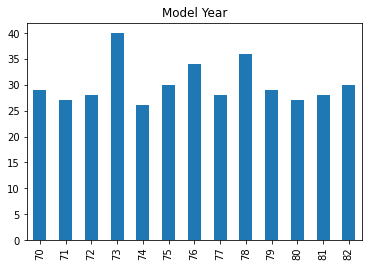

In [14]:
df["model_year"].value_counts().sort_index().plot(kind = "bar", title="Model Year")

In [15]:
bins = pd.IntervalIndex.from_tuples([(69, 73), (74, 77), (78, 82)])
df["model_year"] = pd.cut(df["model_year"], bins = bins)
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin
0,18.0,8,307.0,130.0,3504,12.0,"(69, 73]",usa
1,15.0,8,350.0,165.0,3693,11.5,"(69, 73]",usa
2,18.0,8,318.0,150.0,3436,11.0,"(69, 73]",usa
3,16.0,8,304.0,150.0,3433,12.0,"(69, 73]",usa
4,17.0,8,302.0,140.0,3449,10.5,"(69, 73]",usa


In [16]:
df = pd.get_dummies(df, columns=["model_year", "origin"], drop_first=True)
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,"model_year_(74, 77]","model_year_(78, 82]",origin_japan,origin_usa
0,18.0,8,307.0,130.0,3504,12.0,0,0,0,1
1,15.0,8,350.0,165.0,3693,11.5,0,0,0,1
2,18.0,8,318.0,150.0,3436,11.0,0,0,0,1
3,16.0,8,304.0,150.0,3433,12.0,0,0,0,1
4,17.0,8,302.0,140.0,3449,10.5,0,0,0,1


### Train|test-split

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X, y = df.drop("mpg", axis = 1).values, df["mpg"].values #Picks out the values so we get a numpy array (since tensorflow and kesars does not use dataframe)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
scaler = StandardScaler()

scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

scaled_X_train.shape, scaled_X_test.shape

((274, 9), (118, 9))

### Multiple linear regression

In [18]:
from sklearn.linear_model import LinearRegression

model_lin_reg = LinearRegression()
model_lin_reg.fit(scaled_X_train, y_train)

intercept, coefficients = model_lin_reg.intercept_, model_lin_reg.coef_

intercept, coefficients

(23.637591240875913,
 array([-0.07963534,  0.71698622, -1.5802261 , -4.49219087, -0.08849455,
         0.36793355,  2.76523073,  0.02957218, -1.25074873]))

### Artificial Neural Network (ANN)

- shallow MLP

In [20]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, InputLayer
from tensorflow.keras.optimizers import SGD

model_shallow = Sequential(name = "Shallow_network") #Here we add the input layer
model_shallow.add(InputLayer(X_train.shape[1])) #We specify the number of features
model_shallow.add(Dense(1, name = "Output_layer")) #Note no activation function --> linear activation
#model_shallow.add(Dense(20, name="Hidden_layer")) If we want to create hidden layers
model_shallow.compile(loss = "mean_squared_error", optimizer = SGD(learning_rate=.01))
model_shallow.summary()

Model: "Shallow_network"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Output_layer (Dense)        (None, 1)                 10        
                                                                 
Total params: 10
Trainable params: 10
Non-trainable params: 0
_________________________________________________________________


2022-04-19 11:26:52.224454: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [21]:
model_shallow.fit(scaled_X_train, y_train, epochs = 50, verbose = 1, validation_data=(scaled_X_test, y_test)) #If we were to hyperparameter tune we should also split into validation data

Epoch 1/50
9/9 [==============================] - 1s 29ms/step - loss: 526.1484 - val_loss: 380.2231
Epoch 2/50
9/9 [==============================] - 0s 10ms/step - loss: 357.1112 - val_loss: 256.0151
Epoch 3/50
9/9 [==============================] - 0s 8ms/step - loss: 248.9697 - val_loss: 176.3410
Epoch 4/50
9/9 [==============================] - 0s 7ms/step - loss: 177.0468 - val_loss: 123.1544
Epoch 5/50
9/9 [==============================] - 0s 7ms/step - loss: 126.6593 - val_loss: 86.4428
Epoch 6/50
9/9 [==============================] - 0s 8ms/step - loss: 92.1680 - val_loss: 61.3021
Epoch 7/50
9/9 [==============================] - 0s 7ms/step - loss: 68.0387 - val_loss: 44.1370
Epoch 8/50
9/9 [==============================] - 0s 7ms/step - loss: 50.9513 - val_loss: 32.5651
Epoch 9/50
9/9 [==============================] - 0s 8ms/step - loss: 39.3815 - val_loss: 24.5845
Epoch 10/50
9/9 [==============================] - 0s 8ms/step - loss: 31.0425 - val_loss: 19.2800
Epoch 11

In [23]:
df_loss = pd.DataFrame(model_shallow.history.history) # A dictionary of loss and validation loss
df_loss.head()

,loss,val_loss
0,526.148376,380.223114
1,357.111176,256.015076
2,248.969742,176.341003
3,177.046783,123.154434
4,126.659340,86.442795


In [25]:
df_loss.index = range(1, len(df_loss)+1) #Change the index so that 1 is the first epoch
df_loss.head()

,loss,val_loss
1,526.148376,380.223114
2,357.111176,256.015076
3,248.969742,176.341003
4,177.046783,123.154434
5,126.659340,86.442795


<AxesSubplot:xlabel='Epochs', ylabel='MSE loss'>

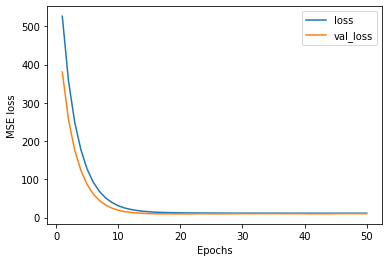

In [28]:
df_loss.plot(xlabel="Epochs", ylabel="MSE loss")

In [30]:
weights, bias = model_shallow.layers[0].get_weights()

print(f"Linear reg: {intercept=}, {coefficients=}")
print(f"ANN {bias=}, {weights=}")

# We get similar values as for linear regression, because we have created a linear network

Linear reg: intercept=23.637591240875913, coefficients=array([-0.07963534,  0.71698622, -1.5802261 , -4.49219087, -0.08849455,
        0.36793355,  2.76523073,  0.02957218, -1.25074873])
ANN bias=array([23.66216], dtype=float32), weights=array([[-0.68277186],
       [-0.2778261 ],
       [-1.9199394 ],
       [-2.845268  ],
       [-0.41614914],
       [ 0.212666  ],
       [ 2.6027896 ],
       [ 0.20080456],
       [-1.0105035 ]], dtype=float32)


### Prediction and evaluation

In [32]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_pred_ANN = model_shallow.predict(scaled_X_test)
y_pred_lin_reg = model_lin_reg.predict(scaled_X_test)

print("MAE, RMSE for ANN:")
print(mean_absolute_error(y_test, y_pred_ANN), np.sqrt(mean_squared_error(y_test, y_pred_ANN)))

print("MAE, RMSE for linear regression:")
print(mean_absolute_error(y_test, y_pred_lin_reg), np.sqrt(mean_squared_error(y_test, y_pred_lin_reg)))

MAE, RMSE for ANN:
2.525539942919197 3.1842735915541605
MAE, RMSE for linear regression:
2.522333542823752 3.1212202349360942
